In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import solar_structure

Solar plasma properties
===================

When considering fluid dynamics within the solar interior, it is useful to have a handle on a number of basic properties that arise from the microphysical transport within the solar plasma.
Here we consider various properties of the solar interior, based on model S.

In [2]:
structure = solar_structure.read_model_S_GONG_format()
R_sun = structure['global']['R'].values[0]
data = structure['data']
data['r/R'] = data['r']/R_sun
mask = (data['r/R']<=0.99)
data = data[mask]

Basic properties
-------------------
We start by plotting some basic properties of the solar interior, here the log density, which gives a sense of the degree of density stratification, and the entropy gradient, which picks out the radiative zone ($\nabla s >0$) and the convection zone ($\nabla s \leq 0$).

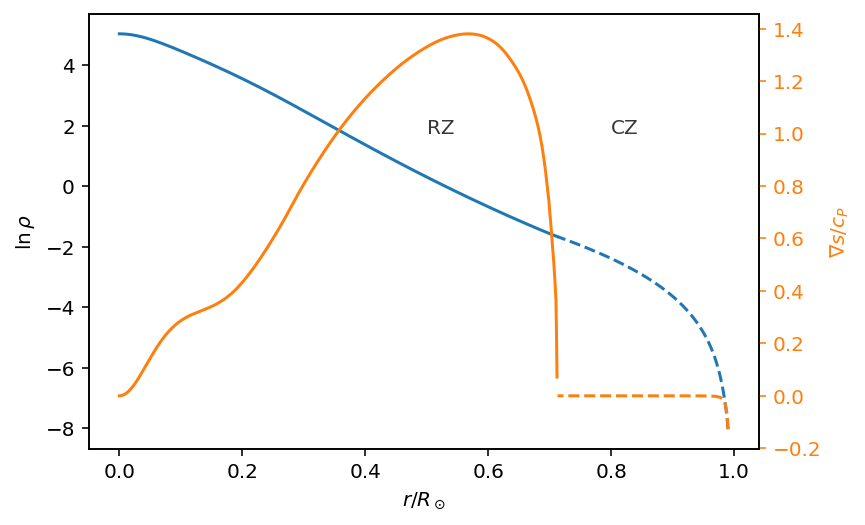

In [3]:
r = data['r/R']

ρ = data['ρ']
grad_s = data['entropy_gradient']

# test on negative entropy gradient, avoid r=0
cz_mask = (grad_s <= 0)*(r > 0.01)

fig, ax = plt.subplots()
p = ax.plot(r[cz_mask], np.log(ρ[cz_mask]), linestyle='dashed')
ax.plot(r[~cz_mask], np.log(ρ[~cz_mask]), color=p[0].get_color())
ax.set_ylabel(r'$\ln \rho$')
ax.set_xlabel(r'$r/R_\odot$')

ax2 = ax.twinx()
s_color = 'tab:orange'
ax2.plot(r[cz_mask], grad_s[cz_mask], color=s_color, linestyle='dashed')
ax2.plot(r[~cz_mask], grad_s[~cz_mask], color=s_color)
ax2.set_ylabel(r'$\nabla s/c_P$')
ax2.yaxis.label.set_color(s_color)
ax2.tick_params(axis='y', colors=s_color)
ax2.text(0.8, 1, 'CZ', color='xkcd:dark grey')
ax2.text(0.5, 1, 'RZ', color='xkcd:dark grey')

ylims = ax.get_ylim()

Plasma properties
---------------------------------
Next we consider some basic plasma properties.

In [4]:
# physical constants
k_B = 1.3e-16 # Boltzman constant, ergs/K
q_e = 4.8e-10 # electron charge in statcoul or esu
N_A = 6.0221e23 # Avagadro's number
m_H = 1.6726e-24 # proton mass, g
m_e = 9.11e-28 # electron mass, g
c = 3e10 # speed of light, cm/s
σ_SB =  5.670374e-5 # Stefan-Boltzman constant, erg/cm^2/s/K^4

We start by calculating the Debye length, the lengthscale over which charge concentrations can occur in a plasma before screening effects kick in.

Considering electrons only, the Debye length is:
\begin{equation}
    \lambda_D = \left(\frac{k_B T}{8 \pi n e^2}\right)^{1/2}
\end{equation}

We further assume (incorrectly) that the plasma is 100% hydrogen and that it's fully ionized.

As can be seen in the figure below, Debye lengths are very, very small within the Sun.

Text(0, 0.5, '$\\lambda_D/R_\\odot$')

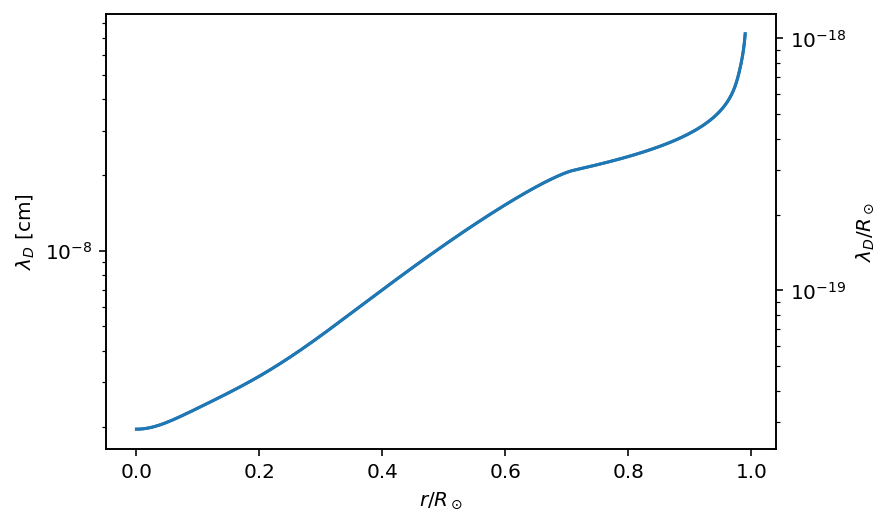

In [5]:
n = data['ρ']/m_H # approximation to 100% Hydrogen
T = data['T']
λ_D = np.sqrt(k_B*T/(8*np.pi*n*q_e**2))
fig, ax = plt.subplots()
ax.plot(r, λ_D)
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda_D$ [cm]')
ax.set_xlabel(r'$r/R_\odot$')
ax2 = ax.twinx()
ax2.plot(r, λ_D/R_sun)
ax2.set_yscale('log')
ax2.set_ylabel(r'$\lambda_D/R_\odot$')

Next we compute Braginskii plasma diffusivities, following the [NRL plasma formulary](https://www.nrl.navy.mil/News-Media/Publications/NRL-Plasma-Formulary/).  

Viscous diffusion
--------------------
We use $\eta^i_0$ as the proxy for the dynamic viscosity of an unmagentized plasmas, with:
\begin{equation}
    \eta^i_0 = 0.96 n k T \tau_i,
\end{equation}
where
\begin{equation}
    \tau_i = \frac{3\sqrt{m_i} (k T)^{3/2}}{4 \sqrt{\pi} n \lambda e^4},
\end{equation}
and where $\lambda$ here is the coulomb logarithm; typically $\lambda \approx 10-20$.

The units on $\eta^i_0$ are in $g/cm/s$, so $\eta^i_0 = \mu$ (the dynamic viscosity) and $\nu$ (the kinematic viscoity):
\begin{equation}
    \nu = \frac{\mu}{\rho} = \frac{\eta^i_0}{\rho}~\mathrm{cm}^2\:\mathrm{s}^{-1}.
\end{equation}.
This aligns with the NRL (2019) expression of the momentum equation 
(pg 36-37, 2019 edition).

In [6]:
λ = 10 # Coulomb logarithm
τ_i = (3*np.sqrt(m_H)*(k_B*T)**(3/2))/(4*np.sqrt(np.pi)*n*λ*q_e**4) # ion collision time
τ_e = (3*np.sqrt(m_e)*(k_B*T)**(3/2))/(4*np.sqrt(np.pi)*n*λ*q_e**4) # electron collision time

η_0 = 0.96*n*k_B*T*τ_i # dynamic diffusivity
ν = η_0/data['ρ'] # kinematic diffusivity

Text(0.5, 0, '$r/R_\\odot$')

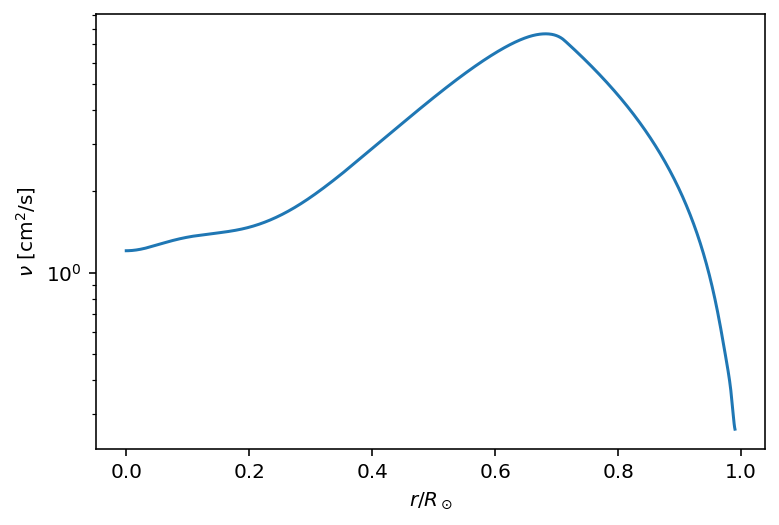

In [7]:
fig, ax = plt.subplots()
ax.plot(r, ν)
ax.set_yscale('log')
ax.set_ylabel(r'$\nu$ [cm$^2$/s]')
ax.set_xlabel(r'$r/R_\odot$')

Magnetic diffusion
----------------------
The magnetic diffusion coefficient (also confusingly $\eta$) is given by:
\begin{equation}
    \eta = \frac{c^2}{4 \pi \sigma} ~\mathrm{cm}^2\:\mathrm{s}^{-1}
\end{equation}
with the conductivity $\sigma$
\begin{equation}
  \sigma \approx \sigma_\parallel = 1.96 \sigma_\perp 
  = 1.96 \frac{Z n_i e^2 \tau_e}{m_e}~\mathrm{s}^{-1}
\end{equation}
and
\begin{equation}
  \eta = \frac{c^2}{4 \pi} \frac{m_e}{1.96 Z n_i e^2 \tau_e}~\mathrm{cm}^2\:\mathrm{s}^{-1}.
\end{equation}

Text(0.5, 0, '$r/R_\\odot$')

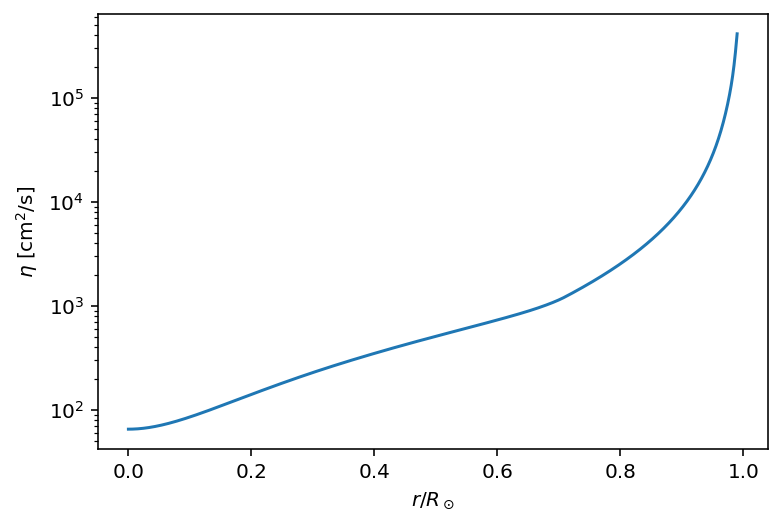

In [8]:
Z = 1 # 100% hydrogen, all fully ionnized
η = c**2/(4*np.pi)*m_e/(1.96*n*Z*q_e**2*τ_e)
fig, ax = plt.subplots()
ax.plot(r, η)
ax.set_yscale('log')
ax.set_ylabel(r'$\eta$ [cm$^2$/s]')
ax.set_xlabel(r'$r/R_\odot$')

Thermal diffusion
--------------------

Thermal diffusion in the solar interior could come from electron conduction in the plasma, which takes the form:

Generally however, thermal diffusion in an opaque, high temperature plasma like the solar interior, is dominated by diffusive radiative transport.  In the opaque limit, radiative transport can be represented by a Fickian diffusion process, with coefficient
\begin{equation}
    K = \frac{16 \sigma_{SB} T^3}{3 \kappa \rho}
\end{equation}
with $\kappa$ the opacity.  This follows Mihalas & Mihalas (1984), their eq (97.3), recognizing that $a_R c = 4 \sigma_{SB}$, and taking $\kappa$ to be the Rosseland mean opacity.  

The thermal diffusivity coefficient $\chi$, is
\begin{equation}
    \chi = \frac{K}{\rho c_P}~\mathrm{cm}^2\:\mathrm{s}^{-1}.
\end{equation}
which follows Mihalas & Mihalas (1984), their eq (101.27), and has units of cm$^2$/s.

Text(0.5, 0, '$r/R_\\odot$')

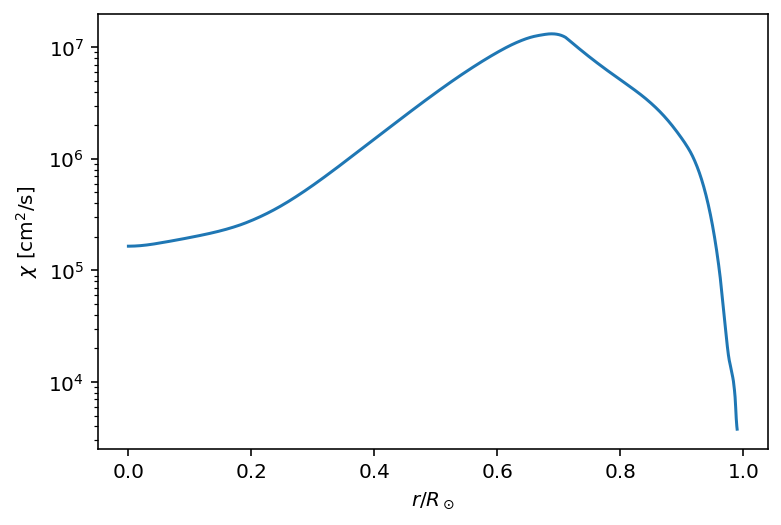

In [9]:
κ = data['κ'] # cm^2/g
c_P = data['c_P']
K = 16*σ_SB*T**3/(3*κ*ρ)
χ = K/(ρ*c_P)
fig, ax = plt.subplots()
ax.plot(r, χ)
ax.set_yscale('log')
ax.set_ylabel(r'$\chi$ [cm$^2$/s]')
ax.set_xlabel(r'$r/R_\odot$')

Representative values
--------------------------

In [19]:
# here's a discrete hack to find a given continuous location in discrete data; 
# might be better to interpolate, but may not make a difference
print('solar interior')
for target_radius in [0, 0.7, 0.966, 1]:
    i = (r-target_radius).abs().idxmin()
    print('r = {:.2f},   ν = {:8.3g},   χ = {:8.3g},   η = {:8.3g}    (all cm^2/s)'.format(r[i], ν[i], χ[i], η[i]))

solar interior
r = 0.00,   ν =      1.2,   χ = 1.65e+05,   η =     65.3    (all cm^2/s)
r = 0.70,   ν =     7.54,   χ =  1.3e+07,   η = 1.14e+03    (all cm^2/s)
r = 0.97,   ν =    0.634,   χ = 5.66e+04,   η = 5.43e+04    (all cm^2/s)
r = 0.99,   ν =    0.263,   χ = 3.78e+03,   η = 4.13e+05    (all cm^2/s)


Non-dimensional parameters of fluid mechanics
--------------------------------------------------------

From these dimensional plasma transport quantities, we can extract several useful non-dimensional parameters for fluid dynamics.  These are the various Prandtl numbers, and the Strebor number (or inverse Roberts number).

The Prandtl number $\mathrm{Pr}$ is:
\begin{equation}
    \mathrm{Pr} = \frac{\nu}{\chi},
\end{equation}
the magnetic Prandtl number $\mathrm{Pm}$ is:
\begin{equation}
    \mathrm{Pm} = \frac{\nu}{\eta},
\end{equation}
and the Strebor number $\mathrm{St}$ is:
\begin{equation}
    \mathrm{St} = \frac{\mathrm{Pr}}{\mathrm{Pm}} = \frac{\eta}{\chi}
\end{equation}



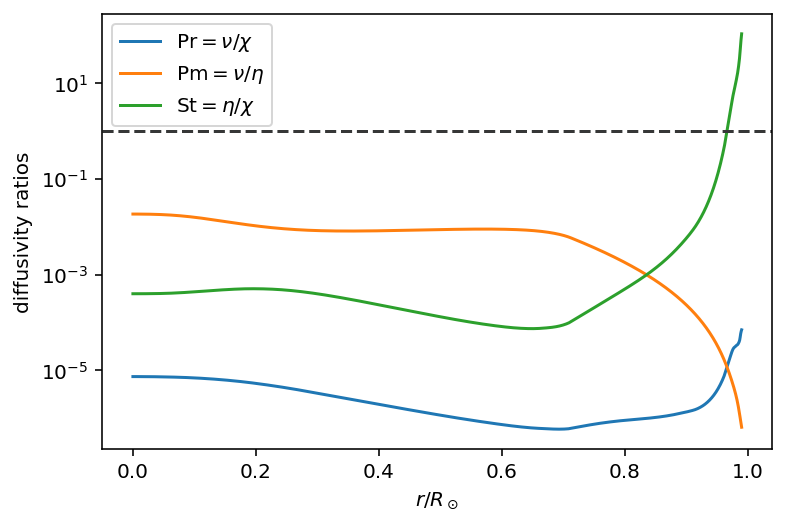

In [15]:
St = η/χ
Pr = ν/χ
Pm = ν/η

fig, ax = plt.subplots()
ax.plot(r, Pr, label=r'$\mathrm{Pr}=\nu/\chi$')
ax.plot(r, Pm, label=r'$\mathrm{Pm}=\nu/\eta$')
ax.plot(r, St, label=r'$\mathrm{St}=\eta/\chi$')
ax.set_yscale('log')
ax.set_ylabel('diffusivity ratios')
ax.set_xlabel(r'$r/R_\odot$')
ax.axhline(y=1, color='xkcd:dark grey', linestyle='dashed')
ax.legend()